#  UNITI Dataset

## Purpose of this Notebook
- [x] Get an statistical overview
    - [x] How many users?
    - [x] How many assessments (= filled out questionnaires)?
    - [x] Date range of the dataset?
    - [x] User-assessment distribution
- [x] Potential features and target for classification and regression   
- [x] Clean the dataset and save cleaned version

In [1]:
# imports
import pandas as pd
from datetime import date, datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

# to import own modules, a workaround - assuming the curent working directory is the folder (your/local/path/UsAs/src/d01_analysis
import sys
sys.path.insert(0, "../..")
from src.d00_utils import helpers

In [2]:
# read data
df = pd.read_csv("../../data/d01_raw/uniti/uniti_dataset_22.09.28.csv")

## Get an statistical overview

### User-assessment distribution

In [3]:
# Check for testusers
s = df.user_id<2101
s.any()

False

**There are no testusers in the dataset!**

In [4]:
# How many users?
print("Number of unique users:", df.user_id.nunique())

Number of unique users: 763


In [5]:
#Split the users into 5 categories based on the number of times they interacted with the app.
df['assessment_quantile'] = df.user_id.map(pd.qcut(df.user_id.value_counts(), 5).to_dict())

In [6]:
#Show the number of users that fall into each 'assessment_quantile' group from above.
pd.DataFrame(df.groupby('assessment_quantile')['user_id'].nunique()).reset_index().rename({'user_id':'n_users'}, axis=1)

,assessment_quantile,n_users
0,"(0.999, 2.0]",183
1,"(2.0, 8.8]",122
2,"(8.8, 35.0]",155
3,"(35.0, 79.0]",152
4,"(79.0, 442.0]",151


In [7]:
#Sanity check, that no user was left out.
print(151+152+155+122+183)


763


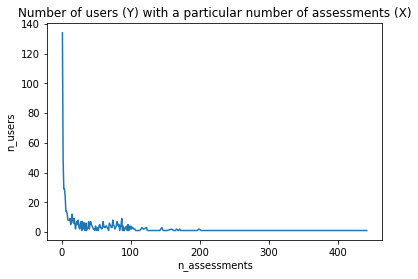

In [8]:
statistic = pd.DataFrame(
        df.user_id.value_counts().sort_values(ascending=True).value_counts()
    ).rename(
        {'index':'length', 'user_id':'n_users'}
    )
ax = sns.lineplot(data=statistic, x=statistic.index, y='user_id')
ax.set_ylabel("n_users")
ax.set_xlabel("n_assessments")
ax.set_title("Number of users (Y) with a particular number of assessments (X)")
print("") #Just my hack to suppress the annoying seaborn output. Dunno how to turn it off, sorry.

##### There are some outlier users with 400+ assessments, just zooming in so you see the real deal

There are some outlier users with 400+ assessments, just zooming in so you see the real deal


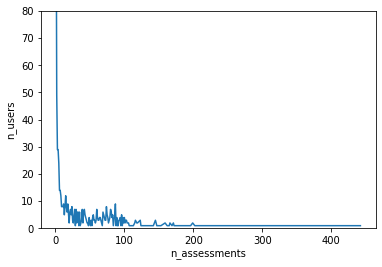

In [9]:
statistic = pd.DataFrame(df.user_id.value_counts().sort_values(ascending=True).value_counts()).rename({'index':'length', 'user_id':'n_users'})
ax = sns.lineplot(data=statistic, x=statistic.index, y='user_id')
ax.set_xlabel("n_assessments")
ax.set_ylabel("n_users")
ax.set_ylim((0,80))
print("There are some outlier users with 400+ assessments, just zooming in so you see the real deal")

In [10]:
uniti_date_info = pd.to_datetime(df.created_at, format="%Y-%m-%d %H:%M:%S", errors='raise').describe(datetime_is_numeric=True)
print("First datestamp:", uniti_date_info['min'], 
      "\n25% of the data comes before:", uniti_date_info['25%'].date(),
     "\n50% of the data comes before:", uniti_date_info['50%'].date(),
     "\n75% of the data comes before:", uniti_date_info['75%'].date(),
     "\nLast datestamp:", uniti_date_info['max'])
print("Total span in days:", (uniti_date_info['max'] - uniti_date_info['min']).days, " days")

First datestamp: 2021-04-13 20:35:15 
25% of the data comes before: 2021-09-12 
50% of the data comes before: 2022-01-23 
75% of the data comes before: 2022-04-30 
Last datestamp: 2022-09-27 22:57:33
Total span in days: 532  days


#### How is the total span of the dataset related to the total span for each user?

##### Please take the n_assessments percentile value with a pinch of salt... The computation is a bit oversimplified, but still hopefully useful to get a sense of the data. If we want to be accurate, we should check the percentile values for n_assessments after filtering only for those users who have X days of data. That will give a clearer idea. 

If that disclaimer was not understandable, sorry. I think it is easier to explain over a call.

#### Date range:

In [11]:
df['date'] = [x.date() for x in pd.to_datetime(df.created_at, format="%Y-%m-%d %H:%M:%S", errors='raise')]
user_date_spans = pd.DataFrame(df.groupby(
                        'user_id', as_index=False).agg(
                            {'date': ['min','max','nunique']}).values, 
                    columns = ['user_id','datestamp_min','datestamp_max', 'n_assessments'])
user_date_spans['time_delta'] = user_date_spans['datestamp_max'] - user_date_spans['datestamp_min']
user_date_spans['n_assessments'] = user_date_spans['n_assessments'].astype(int)

user_date_spans_description = user_date_spans.describe()
print("The shortest user has a date-span of", user_date_spans_description['time_delta']['min'].days
      , "days of data with", user_date_spans_description['n_assessments']['min'], "assessments")

print("25% of the users have", user_date_spans_description['time_delta']['25%'].days, 
      "days of data, with", user_date_spans_description['n_assessments']['25%'],"assessments")
print("50% of the users have", user_date_spans_description['time_delta']['50%'].days, 
      "days of data, with", user_date_spans_description['n_assessments']['50%'],"assessments")
print("75% of the users have", user_date_spans_description['time_delta']['75%'].days, 
      "days of data, with", user_date_spans_description['n_assessments']['75%'],"assessments")



print("Max. is", user_date_spans_description['time_delta']['max'], "days of data with", user_date_spans_description['n_assessments']['max'], "assessments")


print("--------------------------------\nOn average, users have ", user_date_spans_description['time_delta']['mean'].days, 
      "+/-", user_date_spans_description['time_delta']['std'].days ,"days of data, with on average of",
      user_date_spans_description['n_assessments']['mean'], "+/-", user_date_spans_description['n_assessments']['std'], "assessments")



The shortest user has a date-span of 0 days of data with 1.0 assessments
25% of the users have 3 days of data, with 2.0 assessments
50% of the users have 44 days of data, with 16.0 assessments
75% of the users have 93 days of data, with 63.0 assessments
Max. is 504 days 00:00:00 days of data with 433.0 assessments
--------------------------------
On average, users have  68 +/- 83 days of data, with on average of 39.48885976408912 +/- 53.78798975246744 assessments


However, there are both anonymous and non-anonymous participants in the above dataset. If we remove anonymous participants, the statistics are as follows

In [12]:
uniti_non_anon = df[df.user_id < 42101].copy()
uniti_non_anon.loc[:,'assessment_quantile'] = uniti_non_anon.loc[:,'user_id'].map(pd.qcut(uniti_non_anon.user_id.value_counts(), 5).to_dict())

print("The distribution for number of users within a certain range of assessments submitted varies like in the table below:")
pd.DataFrame(uniti_non_anon.groupby('assessment_quantile')['user_id'].nunique()).reset_index().rename({'user_id':'n_users'}, axis=1)

The distribution for number of users within a certain range of assessments submitted varies like in the table below:


,assessment_quantile,n_users
0,"(0.999, 8.0]",110
1,"(8.0, 28.0]",111
2,"(28.0, 60.8]",102
3,"(60.8, 87.4]",108
4,"(87.4, 442.0]",108


In [13]:
# Sanity check
print(110+111+102+108+108, "users in table above, and", uniti_non_anon.user_id.nunique(), " non-anonymous users in the dataset")

539 users in table above, and 539  non-anonymous users in the dataset


In [14]:
uniti_date_info = pd.to_datetime(uniti_non_anon.created_at, format="%Y-%m-%d %H:%M:%S", errors='raise').describe(datetime_is_numeric=True)
print("First datestamp:", uniti_date_info['min'], 
      "\n25% of the data comes before:", uniti_date_info['25%'].date(),
     "\n50% of the data comes before:", uniti_date_info['50%'].date(),
     "\n75% of the data comes before:", uniti_date_info['75%'].date(),
     "\nLast datestamp:", uniti_date_info['max'])
print("Total span in days:", (uniti_date_info['max'] - uniti_date_info['min']).days, " days")

print("The date range doesnt seem to change much, whether we filter out anons or not.")

First datestamp: 2021-04-16 16:16:03 
25% of the data comes before: 2021-09-10 
50% of the data comes before: 2022-01-21 
75% of the data comes before: 2022-04-29 
Last datestamp: 2022-09-27 22:57:33
Total span in days: 529  days
The date range doesnt seem to change much, whether we filter out anons or not.


In [15]:
uniti_non_anon['date'] = [x.date() for x in pd.to_datetime(uniti_non_anon.created_at, format="%Y-%m-%d %H:%M:%S", errors='raise')]
user_date_spans = pd.DataFrame(uniti_non_anon.groupby(
                        'user_id', as_index=False).agg(
                            {'date': ['min','max','nunique']}).values, 
                    columns = ['user_id','datestamp_min','datestamp_max', 'n_assessments'])
user_date_spans['time_delta'] = user_date_spans['datestamp_max'] - user_date_spans['datestamp_min']
user_date_spans['n_assessments'] = user_date_spans['n_assessments'].astype(int)

user_date_spans_description = user_date_spans.describe()
print("The shortest user has a date-span of", user_date_spans_description['time_delta']['min'].days
      , "days of data with", user_date_spans_description['n_assessments']['min'], "assessments")

print("25% of the users have", user_date_spans_description['time_delta']['25%'].days, 
      "days of data, with", user_date_spans_description['n_assessments']['25%'],"assessments")
print("50% of the users have", user_date_spans_description['time_delta']['50%'].days, 
      "days of data, with", user_date_spans_description['n_assessments']['50%'],"assessments")
print("75% of the users have", user_date_spans_description['time_delta']['75%'].days, 
      "days of data, with", user_date_spans_description['n_assessments']['75%'],"assessments")
print("Max. is", user_date_spans_description['time_delta']['max'], "days of data with", user_date_spans_description['n_assessments']['max'], "assessments")
print("--------------------------------\nOn average, users have ", user_date_spans_description['time_delta']['mean'].days, 
      "+/-", user_date_spans_description['time_delta']['std'].days ,"days of data, with on average of",
      user_date_spans_description['n_assessments']['mean'], "+/-", user_date_spans_description['n_assessments']['std'], "assessments")
print("The number of uber-short users drops sharply, because 25% of the users now have data spanning 23 days (with 11 assessments)")

The shortest user has a date-span of 0 days of data with 1.0 assessments
25% of the users have 23 days of data, with 11.0 assessments
50% of the users have 78 days of data, with 39.0 assessments
75% of the users have 109 days of data, with 78.0 assessments
Max. is 504 days 00:00:00 days of data with 433.0 assessments
--------------------------------
On average, users have  87 +/- 85 days of data, with on average of 52.84415584415584 +/- 57.24308872247093 assessments
The number of uber-short users drops sharply, because 25% of the users now have data spanning 23 days (with 11 assessments)


## Potential features and target for classification and regression

####  A candidate for target variable (Regression) is `cumberness`


This is because it is a measure of the distress caused by the disease, and because there is no clear treatment that reliably reduces symptom severity, treating the distress caused by the disease (like in the case of chronic pain) is considered the thing to do, rather than treat the symptom severity.

####  If classification, target variable (`cumberness`) discretisation can be attempted.:

(target in mean +/- user-defined noise threshold is "no change", 
target > mean + threashold is "worse", 
mean - threshold is "better")

#### Candidate for features is all other questions excluding target:

`[loudness, cumberness, jawbone, neck, tin_day, tin_cumber, tin_max, movement, stress, emotion]`

## Clean the dataset and save cleaned version

In [16]:
# created timeshift target
df = helpers.create_target_shift(df, target_name='cumberness')

In [17]:
# reduce dataframe to ML columns
meta_columns = ['user_id', 'created_at']
features = ['loudness', 'cumberness', 'jawbone', 'neck',
            'tin_day', 'tin_cumber', 'tin_max', 'movement', 
            'stress', 'emotion']
target = ['cumberness_t1']

df = df[meta_columns + features + target]

In [18]:
# save to disk
Path("../../data/d02_processed/uniti").mkdir(parents=True, exist_ok=True)
df.to_csv("../../data/d02_processed/uniti/uniti.csv", index_label='answer_id')